___
# Exercice 2
___

Perform a simulation study to investigate the effect of penalized and unpenalized procedures seen throughout the semester, on the estimation of regression coefficients. Consider the linear model:   $$Y = x^T\beta + \epsilon$$
with $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and correlated predictors $x \sim \mathcal{N}(0, \Sigma)$ where $\Sigma$ is a covariance matrix with the value 1 on the diagonal and the constant value $\rho$ for all off-diagonal values. 

In this exercise we will work with two different values for $\rho$ i.e. $\rho = 0.2$ and $0.7$. The vector $\beta$ (of length p) is of the form:    $\beta = (\beta_1, \beta_2, \beta_3, \beta_4, \beta_5, 0, \cdots, 0)^T$.

You are free to choose $\beta_1, \cdots, \beta_5$ and σ such that you distinguish between a low and high SNR = $\frac{Var(f(x))}{Var(\epsilon)}$

Simulate repeatedly (M=1000 repetitions) training and test datasets of size n = 15 and 100 (low sample size vs. high sample size) exhibiting low/high correlation and low/high SNR, from the regression model where p = 10 and 150 (low vs. high-dimensional).
Report on

(i) the accuracy of prediction on the test dataset, <br>
(ii) how well the active set is recovered (average TPR, FPR and FDR),<br>
(iii) how close the estimated values $\hat{\beta}$ are to the true $\beta$ used to generate the data.


___
### Imports and Function Definitions
___

In [2]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import statsmodels.api as sm

In [3]:
# Functions to create dataset

def create_X(n, p, rho):
    """
    Create a design matrix with a given correlation rho
    """
    sigma = np.ones((p, p)) * rho + np.identity(p) * (1 - rho)
    X = np.random.multivariate_normal(np.zeros(p), sigma, n)
    X = np.reshape(X, (n, p))
    return X

def create_y(X, beta, noise_var):
    """
    Create a vector of responses
    """
    n, p = X.shape
    y = np.zeros(n)
    y = np.dot(X, beta) + np.random.normal(0, noise_var, n)
    return y


# Define different penalized and unpenalized models to test

def lm(X, y):
    """
    Unpenalized linear regression
    """
    model = sm.OLS(y, X)
    results = model.fit()
    return results

def ridge(X, y, alpha):
    """
    Ridge regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=0)
    return results

def lasso(X, y, alpha):
    """
    Lasso regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=1)
    return results

def elastic_net(X, y, alpha, l1_ratio):
    """
    Elastic net regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=l1_ratio)
    return results

# Define function to compute scores

def scores(X_train, y_train, X_test, y_test, results, betas):
    
    train_mse = np.mean((y_train - results.predict(X_train))**2)
    test_mse = np.mean((y_test - results.predict(X_test))**2)

    active_set = np.where(results.params != 0)[0]

    p = X_train.shape[1]
    TP = len(np.intersect1d(active_set, betas))
    FP = len(np.setdiff1d(active_set, betas))
    FN = len(np.setdiff1d(betas, active_set))
    TN = len(np.setdiff1d(np.arange(p), np.union1d(active_set, betas)))

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FDR = FP / (FP + TP) if FP + TP > 0 else 0

    betas_error = np.mean((results.params - betas)**2)

    return train_mse, test_mse, TPR, FPR, FDR, betas_error


___
### Experiments
___

### Correlation ($\rho$) Experiment

- $M=1000$
- $n = 100$
- $p = 10$
- $\sigma = 0.1$
- $\beta_{1:5}=1$

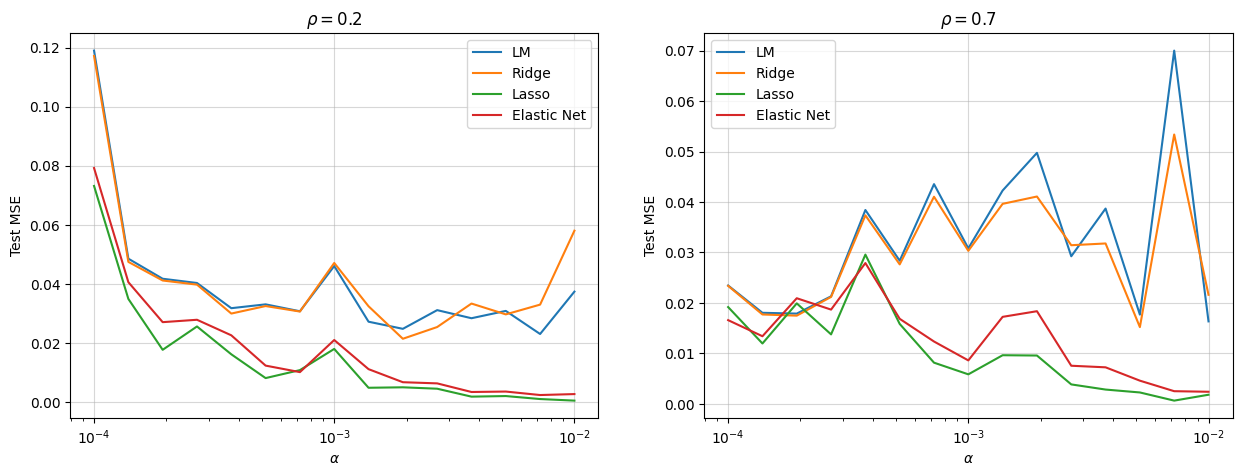

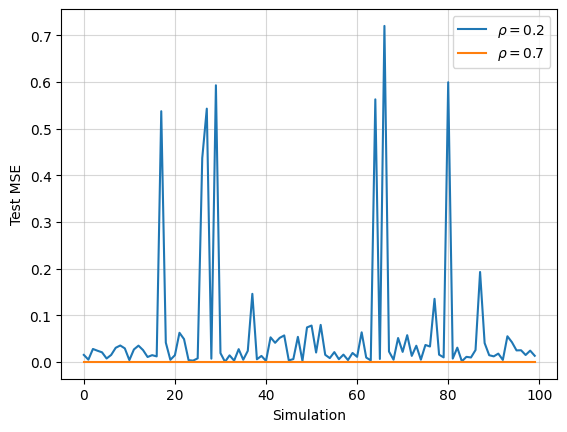

ValueError: Expected 1D or 2D array, got 3D array instead

In [12]:
M=100
n=100
p=10
var_noise=0.1
betas = np.zeros(p)
betas[0:5] = 1

# Find optimal alpha for each model

alphas = np.logspace(-4, -2, 15)
N = 1

lm_test_mse = np.zeros((2, len(alphas)))
ridge_test_mse = np.zeros((2, len(alphas)))
lasso_test_mse = np.zeros((2, len(alphas)))
elastic_net_test_mse = np.zeros((2, len(alphas)))

for i, alpha in enumerate(alphas):
    for j, rho in enumerate([0.2, 0.7]):
        for _ in range(N):
            X_train = create_X(n, p, 0.2)
            y_train = create_y(X_train, betas, var_noise)
            X_test = create_X(M, p, 0.2)
            y_test = create_y(X_test, betas, 0)

            lm_results = lm(X_train, y_train)
            ridge_results = ridge(X_train, y_train, alpha)
            lasso_results = lasso(X_train, y_train, alpha)
            elastic_net_results = elastic_net(X_train, y_train, alpha, 0.5)

            lm_test_mse[j, i] += np.mean((y_test - lm_results.predict(X_test))**2)
            ridge_test_mse[j, i] += np.mean((y_test - ridge_results.predict(X_test))**2)
            lasso_test_mse[j, i] += np.mean((y_test - lasso_results.predict(X_test))**2)
            elastic_net_test_mse[j, i] += np.mean((y_test - elastic_net_results.predict(X_test))**2)

lm_test_mse /= N
ridge_test_mse /= N
lasso_test_mse /= N
elastic_net_test_mse /= N

# Plot optimal alpha

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(alphas, lm_test_mse[0], label="LM")
ax[0].plot(alphas, ridge_test_mse[0], label="Ridge")
ax[0].plot(alphas, lasso_test_mse[0], label="Lasso")
ax[0].plot(alphas, elastic_net_test_mse[0], label="Elastic Net")
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Test MSE")
ax[0].set_title(r"$\rho = 0.2$")
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(alphas, lm_test_mse[1], label="LM")
ax[1].plot(alphas, ridge_test_mse[1], label="Ridge")
ax[1].plot(alphas, lasso_test_mse[1], label="Lasso")
ax[1].plot(alphas, elastic_net_test_mse[1], label="Elastic Net")
ax[1].set_xscale('log')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel("Test MSE")
ax[1].set_title(r"$\rho = 0.7$")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.show()


# Train and test models

lm_scores = np.zeros((2, M, 6))
ridge_scores = np.zeros((2, M, 6))
lasso_scores = np.zeros((2, M, 6))
elastic_net_scores = np.zeros((2, M, 6))

for i, rho in enumerate([0.7]):
    alphas = [0.004, 0.01]
    for j in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, 0)

        lm_results = lm(X_train, y_train)
        ridge_results = ridge(X_train, y_train, alphas[i])
        lasso_results = lasso(X_train, y_train, alphas[i])
        elastic_net_results = elastic_net(X_train, y_train, alphas[i], 0.5)

        lm_scores[i, j] = scores(X_train, y_train, X_test, y_test, lm_results, betas)
        ridge_scores[i, j] = scores(X_train, y_train, X_test, y_test, ridge_results, betas)
        lasso_scores[i, j] = scores(X_train, y_train, X_test, y_test, lasso_results, betas)
        elastic_net_scores[i, j] = scores(X_train, y_train, X_test, y_test, elastic_net_results, betas)

plt.plot(lasso_scores[0, :, 1], label=r"$\rho = 0.2$")
plt.plot(lasso_scores[1, :, 1], label=r"$\rho = 0.7$")
plt.xlabel("Simulation")
plt.ylabel("Test MSE")
plt.legend()
plt.grid(alpha=0.5)
plt.show()
    
lm_scores /= M
ridge_scores /= M
lasso_scores /= M
elastic_net_scores /= M

# Save scores
    
np.savetxt("./ResultsEx2/lm_scores_rho.csv", lm_scores, delimiter=",")   
np.savetxt("./ResultsEx2/ridge_scores_rho.csv", ridge_scores, delimiter=",")
np.savetxt("./ResultsEx2/lasso_scores_rho.csv", lasso_scores, delimiter=",")
np.savetxt("./ResultsEx2/elastic_net_scores_rho.csv", elastic_net_scores, delimiter=",")


In [22]:
test_mse = np.zeros((2, 4))

test_mse[0, 0] = lm_scores[0, 1]
test_mse[0, 1] = ridge_scores[0, 1]
test_mse[0, 2] = lasso_scores[0, 1]
test_mse[0, 3] = elastic_net_scores[0, 1]

test_mse[1, 0] = lm_scores[1, 1]
test_mse[1, 1] = ridge_scores[1, 1]
test_mse[1, 2] = lasso_scores[1, 1]
test_mse[1, 3] = elastic_net_scores[1, 1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(4), test_mse[0], label=r"$\rho = 0.2$")
plt.xticks(np.arange(4), ["LM", "Ridge", "Lasso", "Elastic Net"])
plt.ylabel("Test MSE")
plt.subplot(1, 2, 2)
plt.bar(np.arange(4), test_mse[1], label=r"$\rho = 0.7$")
plt.xticks(np.arange(4), ["LM", "Ridge", "Lasso", "Elastic Net"])
plt.legend()
plt.grid(alpha=0.5)



ValueError: setting an array element with a sequence.

#### Variance of Noise ($\sigma$) Experiment

- $M=1000$
- $n = 100$
- $p = 10$
- $\rho = 0.2$
- $\beta_{1:5}=1$


In [22]:
M=1000
n=100
p=10
rho=0.2
betas = np.zeros(p)
betas[0:5] = 1

lm_scores = np.zeros((2, 6))
ridge_scores = np.zeros((2, 6))
lasso_scores = np.zeros((2, 6))
elastic_net_scores = np.zeros((2, 6))

for i, var_noise in enumerate([0.1, 10]):
    for _ in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, 0)

        lm_results = lm(X_train, y_train)
        ridge_results = ridge(X_train, y_train, 0.004)
        lasso_results = lasso(X_train, y_train, 0.004)
        elastic_net_results = elastic_net(X_train, y_train, 0.004, 0.5)

        lm_scores[i] += scores(X_train, y_train, X_test, y_test, lm_results, betas)
        ridge_scores[i] += scores(X_train, y_train, X_test, y_test, ridge_results, betas)
        lasso_scores[i] += scores(X_train, y_train, X_test, y_test, lasso_results, betas)
        elastic_net_scores[i] += scores(X_train, y_train, X_test, y_test, elastic_net_results, betas)
    
    lm_scores[i] /= M
    ridge_scores[i] /= M
    lasso_scores[i] /= M
    elastic_net_scores[i] /= M

# Save scores

np.savetxt("./ResultsEx2/lm_scores_noise.csv", lm_scores, delimiter=",")
np.savetxt("./ResultsEx2/ridge_scores_noise.csv", ridge_scores, delimiter=",")
np.savetxt("./ResultsEx2/lasso_scores_noise.csv", lasso_scores, delimiter=",")
np.savetxt("./ResultsEx2/elastic_net_scores_noise.csv", elastic_net_scores, delimiter=",")

#### Sample Size ($n$) Experiment

- $M=1000$
- $p = 10$
- $\rho = 0.2$
- $\sigma = 0.1$
- $\beta_{1:5}=1$


In [23]:
M=1000
n=100
p=10
rho=0.2
var_noise=0.1
betas = np.zeros(p)
betas[0:5] = 1

lm_scores = np.zeros((2, 6))
ridge_scores = np.zeros((2, 6))
lasso_scores = np.zeros((2, 6))
elastic_net_scores = np.zeros((2, 6))

for i, n in enumerate([10, 100]):
    for _ in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, 0)

        lm_results = lm(X_train, y_train)
        ridge_results = ridge(X_train, y_train, 0.004)
        lasso_results = lasso(X_train, y_train, 0.004)
        elastic_net_results = elastic_net(X_train, y_train, 0.004, 0.5)

        lm_scores[i] += scores(X_train, y_train, X_test, y_test, lm_results, betas)
        ridge_scores[i] += scores(X_train, y_train, X_test, y_test, ridge_results, betas)
        lasso_scores[i] += scores(X_train, y_train, X_test, y_test, lasso_results, betas)
        elastic_net_scores[i] += scores(X_train, y_train, X_test, y_test, elastic_net_results, betas)
    
    lm_scores[i] /= M
    ridge_scores[i] /= M
    lasso_scores[i] /= M
    elastic_net_scores[i] /= M

# Save scores

np.savetxt("./ResultsEx2/lm_scores_n.csv", lm_scores, delimiter=",")
np.savetxt("./ResultsEx2/ridge_scores_n.csv", ridge_scores, delimiter=",")
np.savetxt("./ResultsEx2/lasso_scores_n.csv", lasso_scores, delimiter=",")
np.savetxt("./ResultsEx2/elastic_net_scores_n.csv", elastic_net_scores, delimiter=",")

#### Dimensionality ($p$) Experiment

- $M=1000$
- $n = 100$
- $\rho = 0.2$
- $\sigma = 0.1$
- $\beta_{1:5}=1$

In [25]:
M=1000
n=100
rho=0.2
var_noise=0.1

lm_scores = np.zeros((2, 6))
ridge_scores = np.zeros((2, 6))
lasso_scores = np.zeros((2, 6))
elastic_net_scores = np.zeros((2, 6))

for i, p in enumerate([10, 100]):
    betas = np.zeros(p)
    betas[0:5] = 1
    for _ in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, 0)

        lm_results = lm(X_train, y_train)
        ridge_results = ridge(X_train, y_train, 0.004)
        lasso_results = lasso(X_train, y_train, 0.004)
        elastic_net_results = elastic_net(X_train, y_train, 0.004, 0.5)

        lm_scores[i] += scores(X_train, y_train, X_test, y_test, lm_results, betas)
        ridge_scores[i] += scores(X_train, y_train, X_test, y_test, ridge_results, betas)
        lasso_scores[i] += scores(X_train, y_train, X_test, y_test, lasso_results, betas)
        elastic_net_scores[i] += scores(X_train, y_train, X_test, y_test, elastic_net_results, betas)
    
    lm_scores[i] /= M
    ridge_scores[i] /= M
    lasso_scores[i] /= M
    elastic_net_scores[i] /= M

# Save scores

np.savetxt("./ResultsEx2/lm_scores_p.csv", lm_scores, delimiter=",")
np.savetxt("./ResultsEx2/ridge_scores_p.csv", ridge_scores, delimiter=",")
np.savetxt("./ResultsEx2/lasso_scores_p.csv", lasso_scores, delimiter=",")
np.savetxt("./ResultsEx2/elastic_net_scores_p.csv", elastic_net_scores, delimiter=",")

___
### Results
___

In [22]:
style.use('ggplot')

def show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, label, values):

    lm_02_01 = lm_scores[0]
    lm_07_01 = lm_scores[1]
    ridge_02_01 = ridge_scores[0]
    ridge_07_01 = ridge_scores[1]
    lasso_02_01 = lasso_scores[0]
    lasso_07_01 = lasso_scores[1]
    elastic_net_02_01 = elastic_net_scores[0]
    elastic_net_07_01 = elastic_net_scores[1]

    models = ['lm', 'ridge', 'lasso', 'elastic_net']

    ### Plots MSE

    mse_02 = {
        'Train': (lm_02_01[0], ridge_02_01[0], lasso_02_01[0], elastic_net_02_01[0]),
        'Test': (lm_02_01[1], ridge_02_01[1], lasso_02_01[1], elastic_net_02_01[1])
    }

    mse_07 = {
        'Train': (lm_07_01[0], ridge_07_01[0], lasso_07_01[0], elastic_net_07_01[0]),
        'Test': (lm_07_01[1], ridge_07_01[1], lasso_07_01[1], elastic_net_07_01[1])
    }

    x = np.arange(len(models))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    rects1 = ax1.bar(x - width/2, mse_02['Train'], width, label='Train', alpha=0.8)
    rects2 = ax1.bar(x + width/2, mse_02['Test'], width, label='Test', alpha=0.8)
    ax1.set_ylabel('MSE')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.set_title('{} = {}'.format(label, values[0]))

    rects1 = ax2.bar(x - width/2, mse_07['Train'], width, label='Train', alpha=0.8)
    rects2 = ax2.bar(x + width/2, mse_07['Test'], width, label='Test', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()
    ax2.set_title('{} = {}'.format(label, values[1]))

    fig.tight_layout()
    plt.savefig('./ResultsEx2/mse_'+label+'.png')
    plt.show()

    ### Plots TPR, FPR and FDR

    ratios_02 = {
        'TPR': (lm_02_01[2], ridge_02_01[2], lasso_02_01[2], elastic_net_02_01[2]),
        'FPR': (lm_02_01[3], ridge_02_01[3], lasso_02_01[3], elastic_net_02_01[3]),
        'FDR': (lm_02_01[4], ridge_02_01[4], lasso_02_01[4], elastic_net_02_01[4])
    }

    ratios_07 = {
        'TPR': (lm_07_01[2], ridge_07_01[2], lasso_07_01[2], elastic_net_07_01[2]),
        'FPR': (lm_07_01[3], ridge_07_01[3], lasso_07_01[3], elastic_net_07_01[3]),
        'FDR': (lm_07_01[4], ridge_07_01[4], lasso_07_01[4], elastic_net_07_01[4])
    }

    x = np.arange(len(models))
    width = 0.2

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    rects1 = ax1.bar(x - width, ratios_02['TPR'], width, label='TPR', alpha=0.8)
    rects2 = ax1.bar(x, ratios_02['FPR'], width, label='FPR', alpha=0.8)
    rects3 = ax1.bar(x + width, ratios_02['FDR'], width, label='FDR', alpha=0.8)

    ax1.set_ylabel('Ratio')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.set_title('{} = {}'.format(label, values[0]))

    rects1 = ax2.bar(x - width, ratios_07['TPR'], width, label='TPR', alpha=0.8)
    rects2 = ax2.bar(x, ratios_07['FPR'], width, label='FPR', alpha=0.8)
    rects3 = ax2.bar(x + width, ratios_07['FDR'], width, label='FDR', alpha=0.8)

    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()
    ax2.set_title('{} = {}'.format(label, values[1]))

    fig.tight_layout()
    plt.savefig('./ResultsEx2/ratios_'+label+'.png')
    plt.show()

    ### Plots betas error

    betas_error_02 = {
        'lm': lm_02_01[5],
        'ridge': ridge_02_01[5],
        'lasso': lasso_02_01[5],
        'elastic_net': elastic_net_02_01[5],
    }

    betas_error_07 = {
        'lm': lm_07_01[5],
        'ridge': ridge_07_01[5],
        'lasso': lasso_07_01[5],
        'elastic_net': elastic_net_07_01[5],
    }

    x = np.arange(len(models))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    rects1 = ax1.bar(x - width/2, betas_error_02.values(), width, alpha=0.8)
    ax1.set_ylabel('Betas error')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.set_title('{} = {}'.format(label, values[0]))

    rects1 = ax2.bar(x, betas_error_07.values(), width, alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.set_title('{} = {}'.format(label, values[1]))

    fig.tight_layout()
    plt.savefig('./ResultsEx2/betas_error_'+label+'.png')
    plt.show()


#### Correlation ($\rho$) Experiment Results

In [15]:
lm_scores = np.loadtxt("./ResultsEx2/lm_scores_rho.csv", delimiter=",")
ridge_scores = np.loadtxt("./ResultsEx2/ridge_scores_rho.csv", delimiter=",")
lasso_scores = np.loadtxt("./ResultsEx2/lasso_scores_rho.csv", delimiter=",")
elastic_net_scores = np.loadtxt("./ResultsEx2/elastic_net_scores_rho.csv", delimiter=",")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, 'rho', [0.2, 0.7])

/tmp/ipykernel_699290/2128328766.py:1: UserWarning: loadtxt: input contained no data: "./ResultsEx2/lm_scores_rho.csv"
  lm_scores = np.loadtxt("./ResultsEx2/lm_scores_rho.csv", delimiter=",")


IndexError: index 0 is out of bounds for axis 0 with size 0

#### Variance of Noise ($\sigma$) Experiment Results

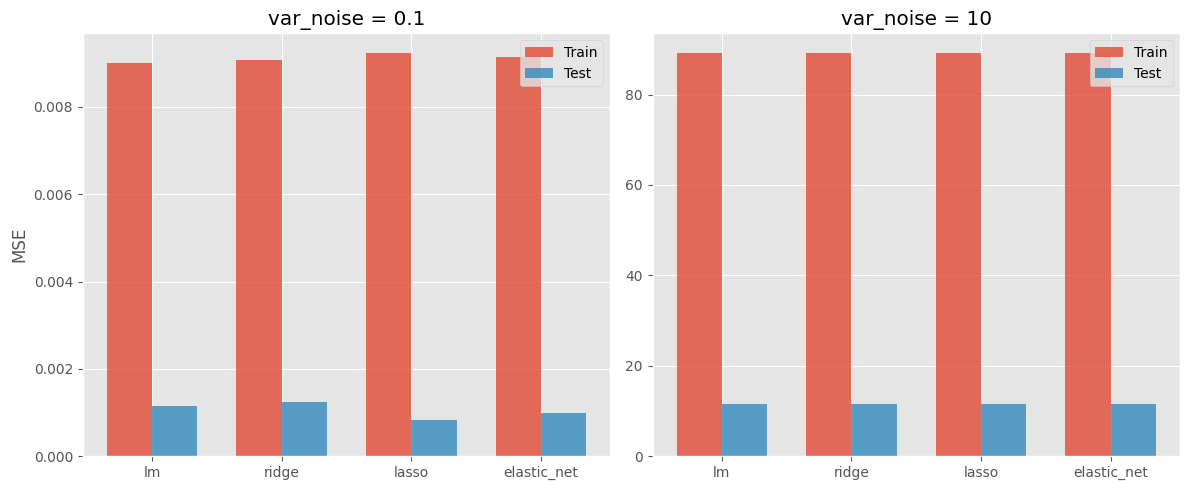

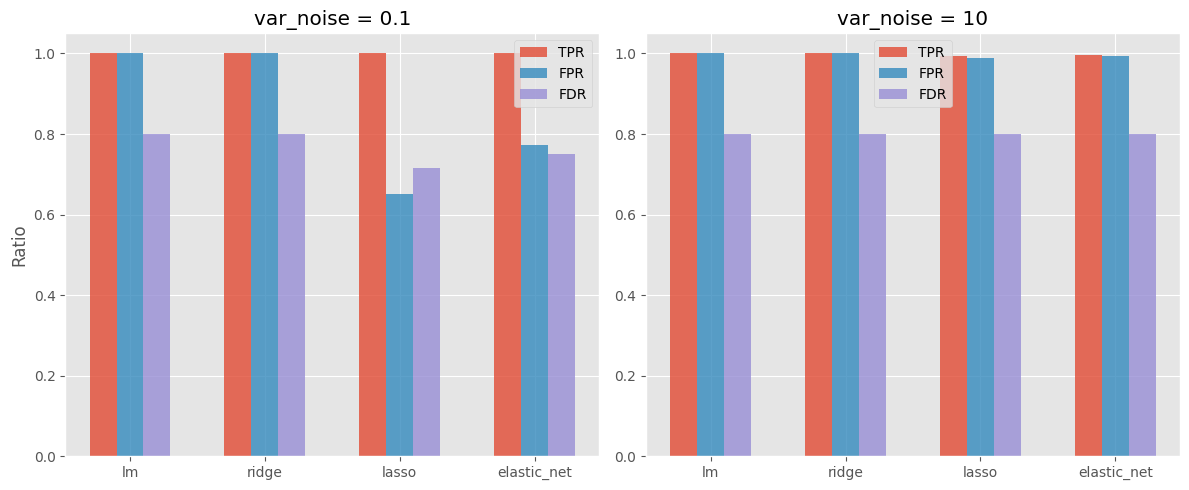

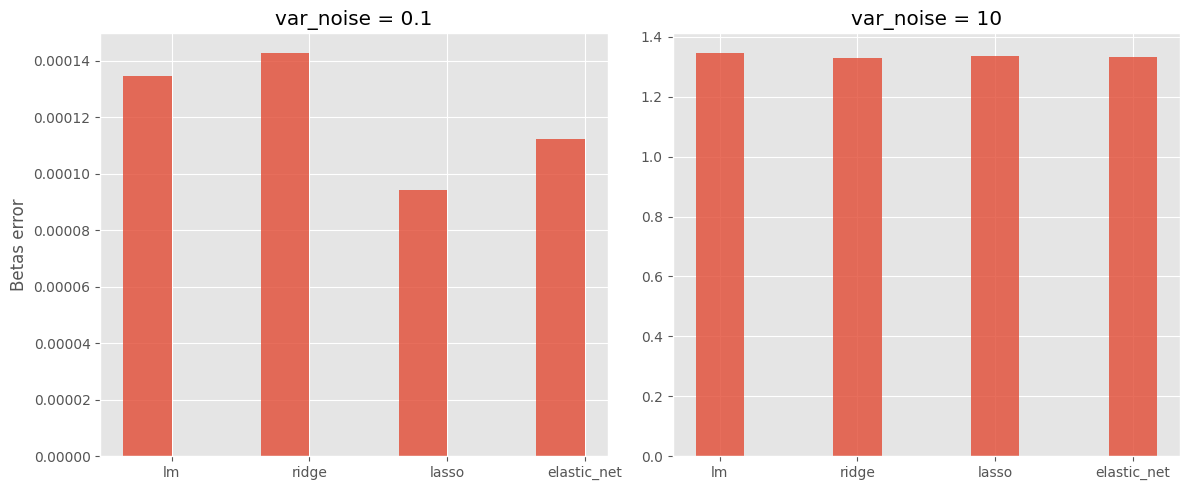

In [23]:
lm_scores = np.loadtxt("./ResultsEx2/lm_scores_noise.csv", delimiter=",")
ridge_scores = np.loadtxt("./ResultsEx2/ridge_scores_noise.csv", delimiter=",")
lasso_scores = np.loadtxt("./ResultsEx2/lasso_scores_noise.csv", delimiter=",")
elastic_net_scores = np.loadtxt("./ResultsEx2/elastic_net_scores_noise.csv", delimiter=",")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, 'var_noise', [0.1, 10])

#### Sample Size ($n$) Experiment Results

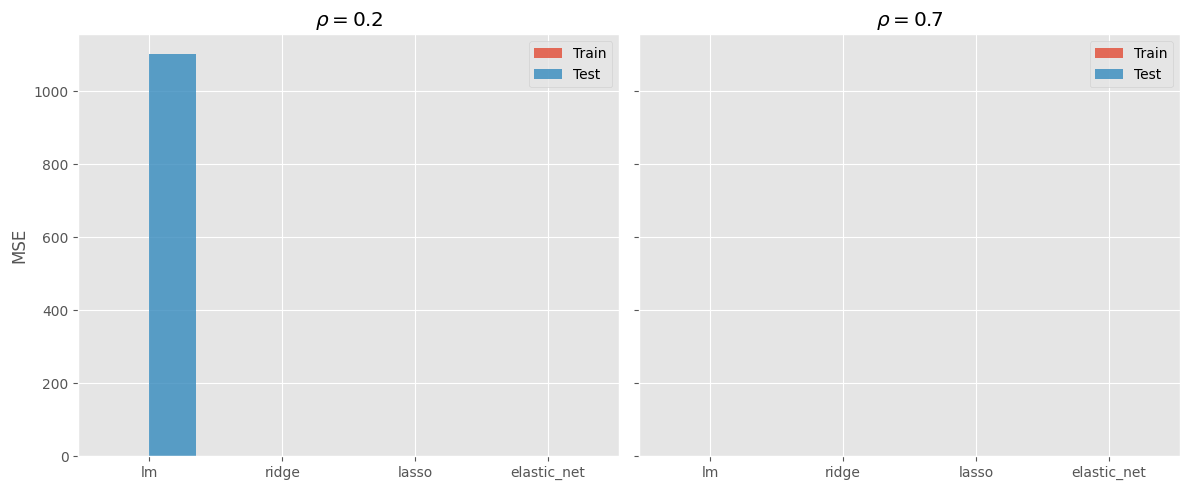

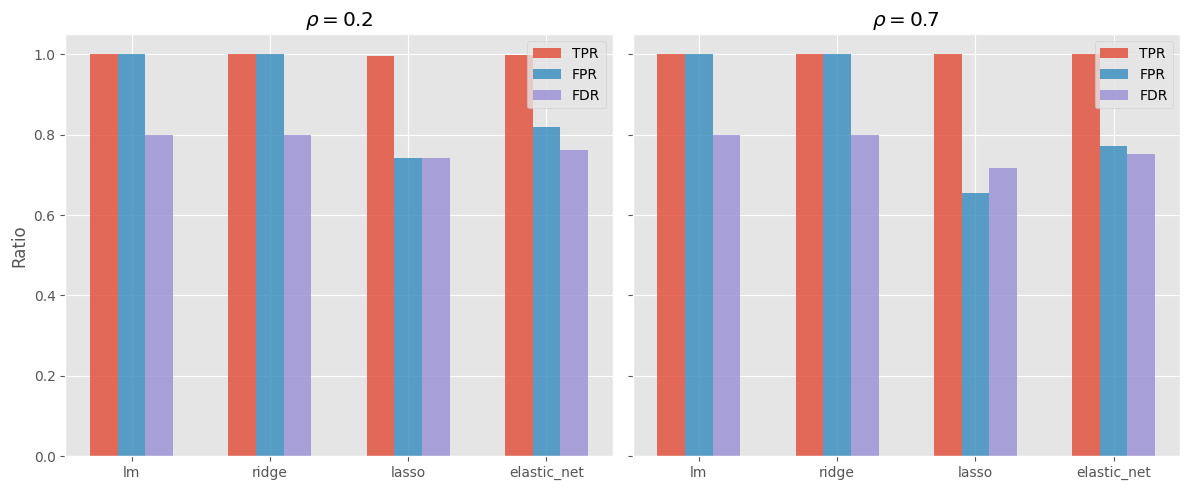

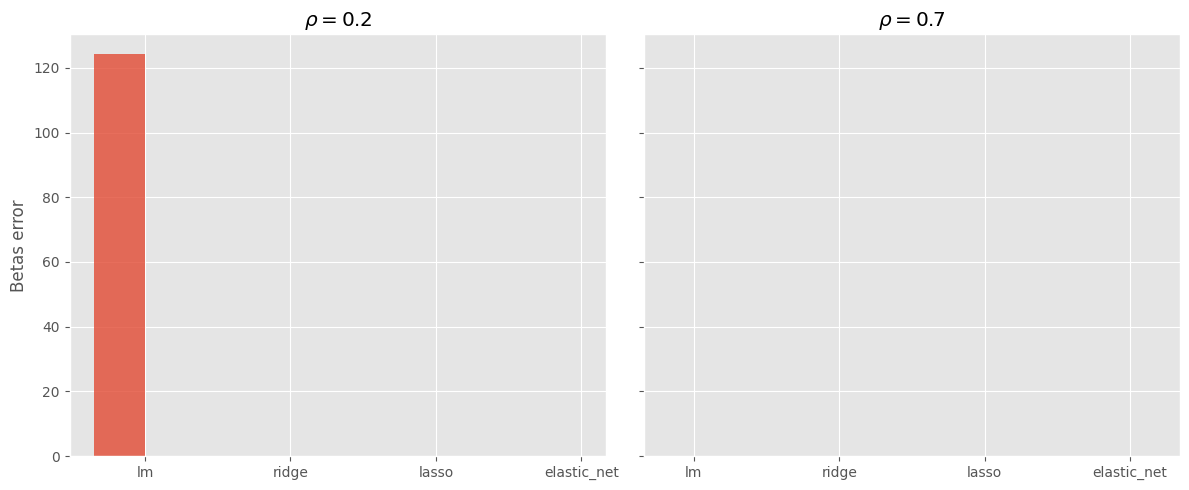

In [32]:
lm_scores = np.loadtxt("./ResultsEx2/lm_scores_n.csv", delimiter=",")
ridge_scores = np.loadtxt("./ResultsEx2/ridge_scores_n.csv", delimiter=",")
lasso_scores = np.loadtxt("./ResultsEx2/lasso_scores_n.csv", delimiter=",")
elastic_net_scores = np.loadtxt("./ResultsEx2/elastic_net_scores_n.csv", delimiter=",")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, 'n')

#### Dimensionality ($p$) Experiment Results

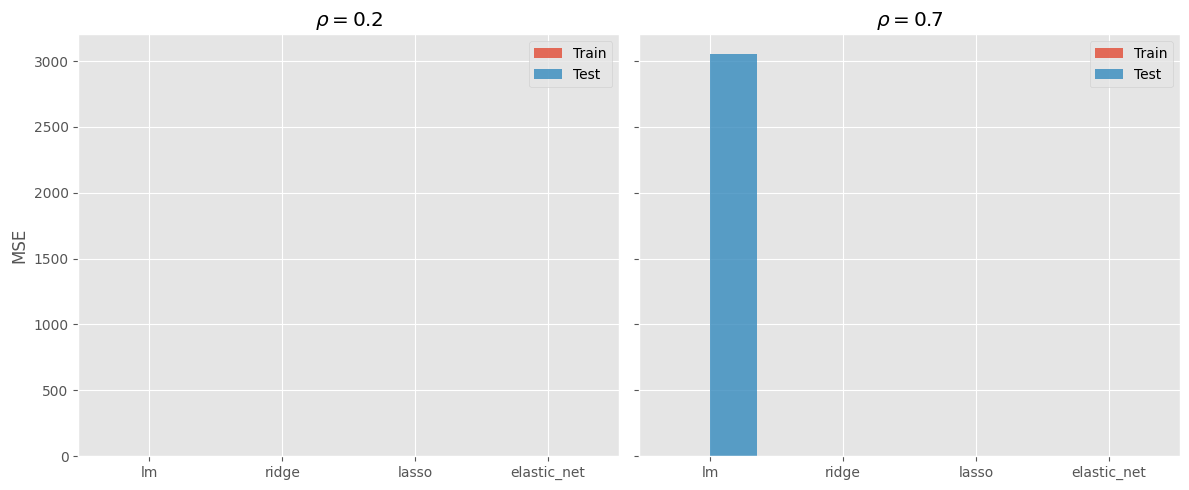

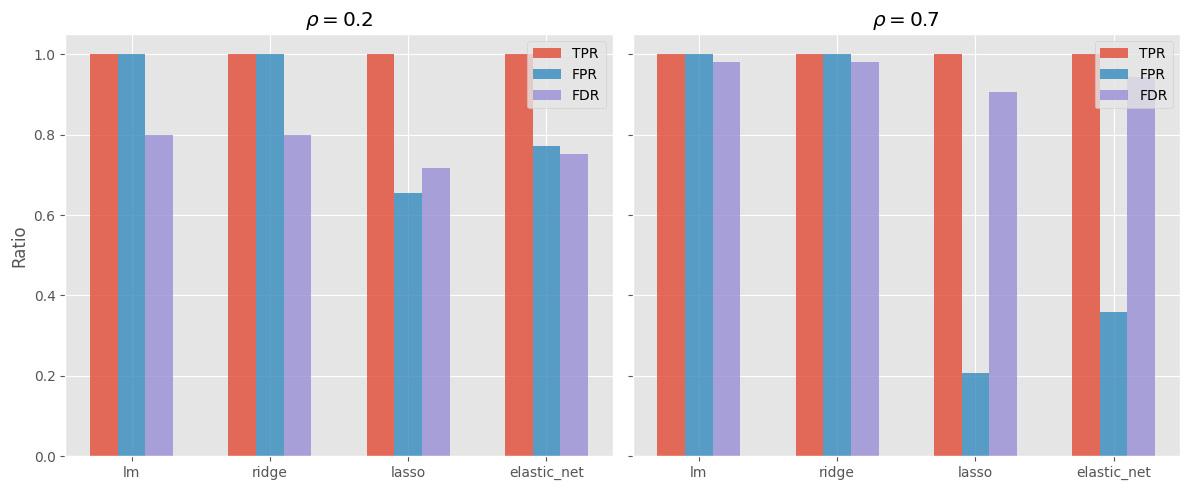

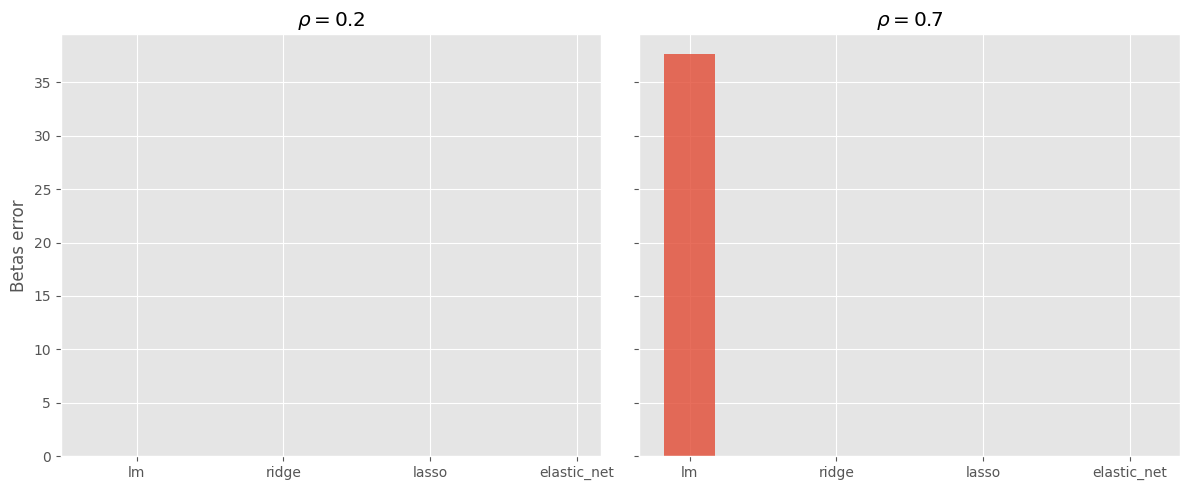

In [33]:
lm_scores = np.loadtxt("./ResultsEx2/lm_scores_p.csv", delimiter=",")
ridge_scores = np.loadtxt("./ResultsEx2/ridge_scores_p.csv", delimiter=",")
lasso_scores = np.loadtxt("./ResultsEx2/lasso_scores_p.csv", delimiter=",")
elastic_net_scores = np.loadtxt("./ResultsEx2/elastic_net_scores_p.csv", delimiter=",")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, 'p')